In [1]:
import os
import time
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from turtle import color
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  #close copy warning   

In [2]:
property_df = pd.read_csv("../data/curated/data.csv")

In [3]:
property_df.head(2)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,Flagstaff Railway Station (Melbourne City),41.4,282.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,MELBOURNE,3000,Studio,1,0,0,1,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,Parliament Railway Station (Melbourne City),117.8,762.1


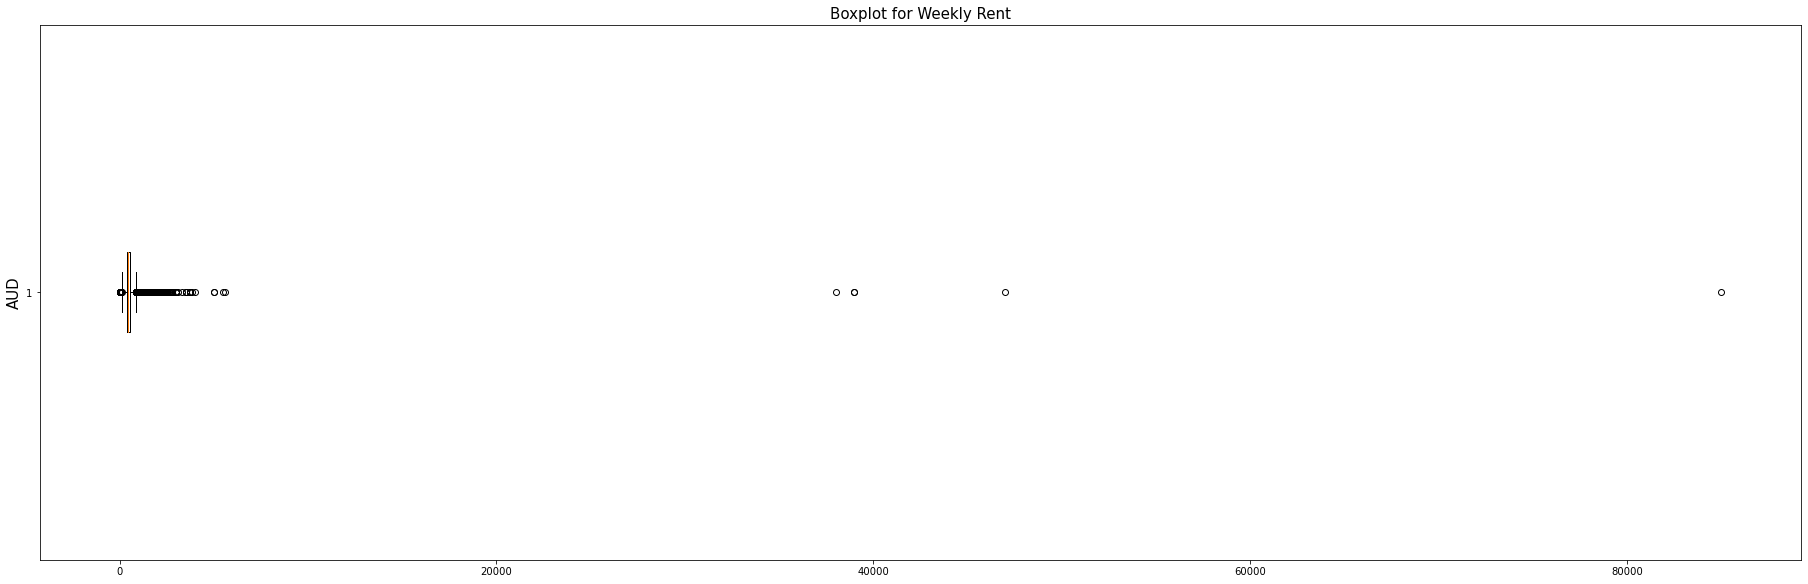

In [4]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(property_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_before.png')

/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'weekly rent distribution'}, xlabel='rent_weekly', ylabel='Density'>

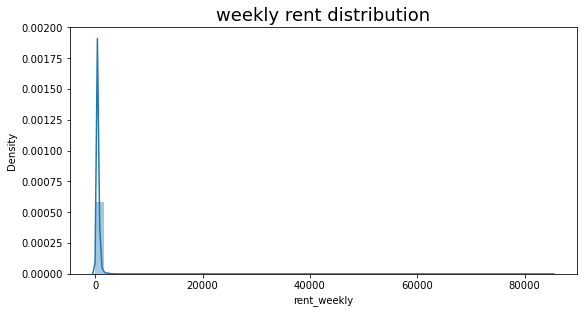

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution', fontsize=18)
sns.distplot(property_df['rent_weekly'])

In [6]:
property_df["rent_weekly"].describe()

count    14505.000000
mean       531.953326
std       1008.667255
min          1.000000
25%        385.000000
50%        450.000000
75%        570.000000
max      85000.000000
Name: rent_weekly, dtype: float64

In [7]:
Q1 = property_df["rent_weekly"].quantile(0.25)
Q3 = property_df["rent_weekly"].quantile(0.75)
IQR = Q3 - Q1
property_df = property_df[~((property_df["rent_weekly"] < (Q1 - 1.5 * IQR)) | (property_df["rent_weekly"] > (Q3 + 1.5 * IQR)))]
property_df = property_df.reset_index(drop=True)

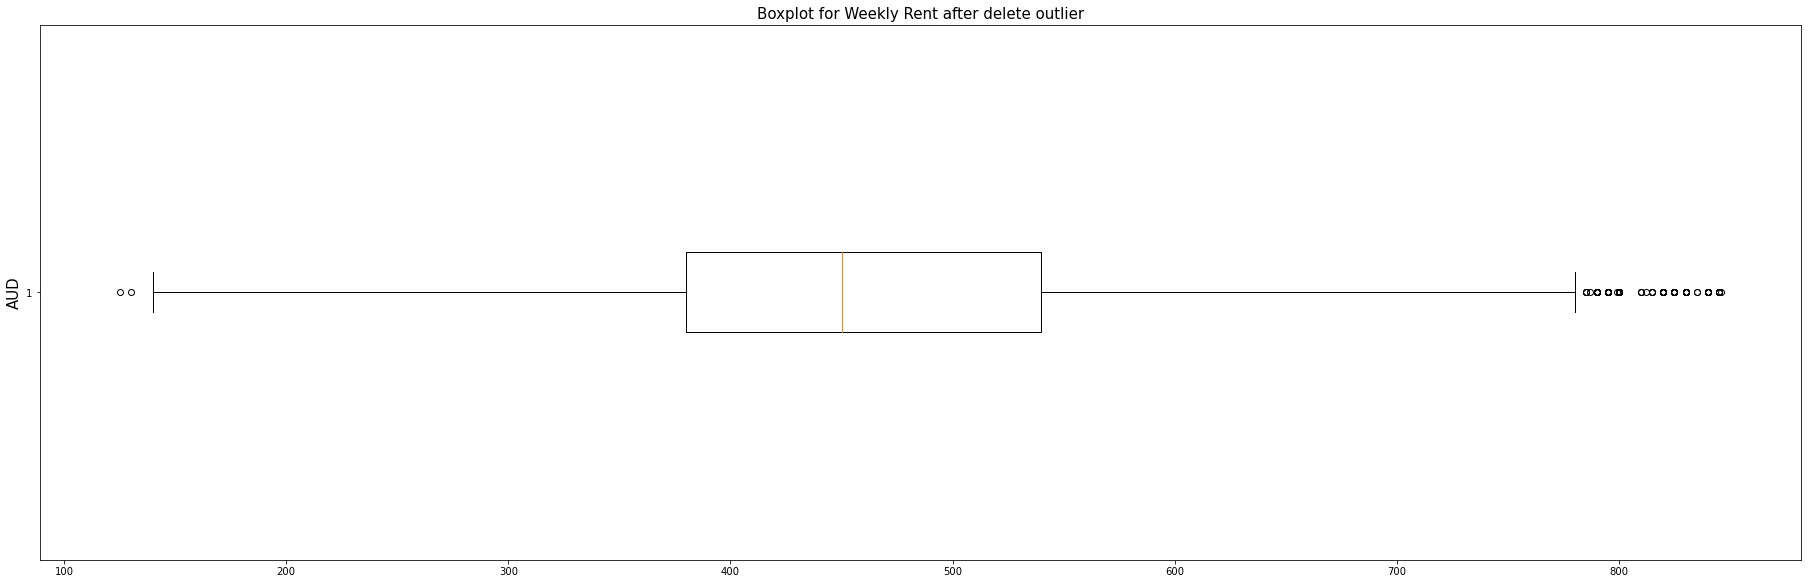

In [8]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(property_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent after delete outlier',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_after.png')

/Users/lucinda/opt/anaconda3/envs/ads_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'weekly rent distribution after delete outlier'}, xlabel='rent_weekly', ylabel='Density'>

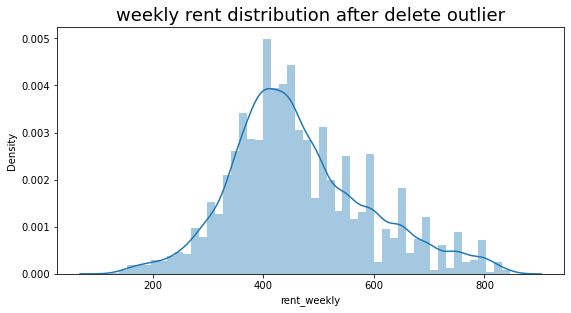

In [22]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution after delete outlier', fontsize=18)
sns.distplot(property_df['rent_weekly'])

In [19]:
property_df.to_csv("../data/curated/data_delete_outlier.csv",index=False)

In [20]:
property_df.shape

(13455, 111)

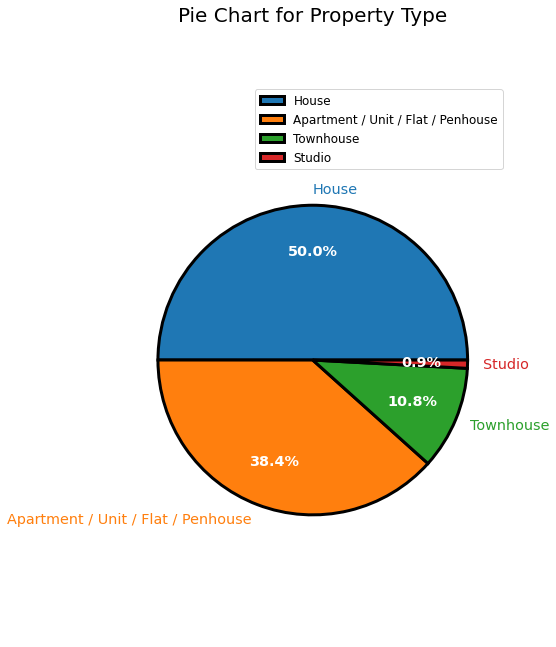

In [9]:
pie_data = property_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,9))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [10]:
property_df['counts'] = 1

In [11]:
count_number = property_df.groupby('suburb').agg('count')[['counts']].reset_index()
count_number

,suburb,counts
0,ABBOTSFORD,40
1,ABERFELDIE,11
2,ADAMS ESTATE,6
3,ADDINGTON,4
4,ADELAIDE LEAD,1
...,...,...
565,YARRAGON,1
566,YARRAM,1
567,YARRAVILLE,65
568,YARRAWONGA,16


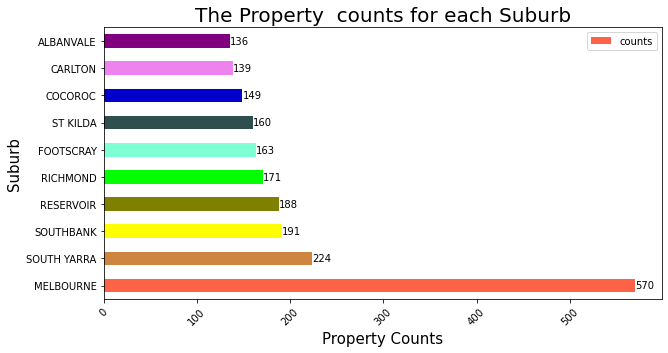

In [12]:
data = count_number.sort_values(by=['counts'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="counts",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine',
                            'darkslategray', 'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Property Counts", fontsize=15)
plt.title("The Property  counts for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/property_count.png')

In [13]:
mean_suburb = property_df.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
mean_suburb

,suburb,rent_weekly
0,ABBOTSFORD,571.875000
1,ABERFELDIE,490.454545
2,ADAMS ESTATE,470.833333
3,ADDINGTON,388.750000
4,ADELAIDE LEAD,380.000000
...,...,...
565,YARRAGON,420.000000
566,YARRAM,585.000000
567,YARRAVILLE,437.907692
568,YARRAWONGA,386.562500


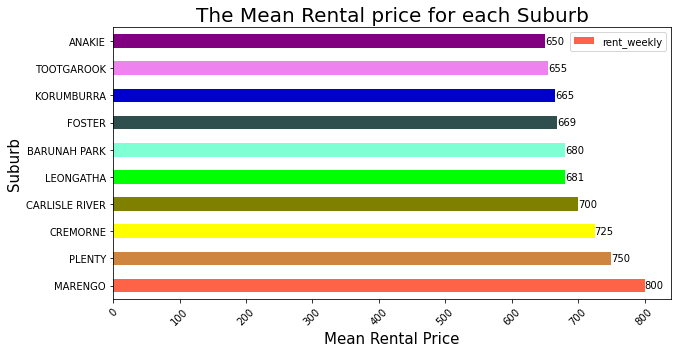

In [14]:
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price", fontsize=15)
plt.title("The Mean Rental price for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/suburb_mean.png')

In [15]:
property_df['type']= property_df['type'].replace('Townhouse','House')

In [16]:
apa = property_df[property_df['type'] == 'Apartment / Unit / Flat / Penhouse']
house = property_df[property_df['type'] == 'House']
#townhouse = property_df[property_df['type'] == 'Townhouse']

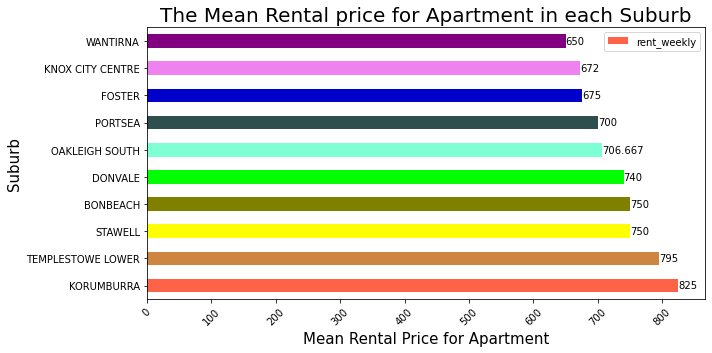

In [17]:
mean_suburb = apa.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for Apartment", fontsize=15)
plt.title("The Mean Rental price for Apartment in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean.png')

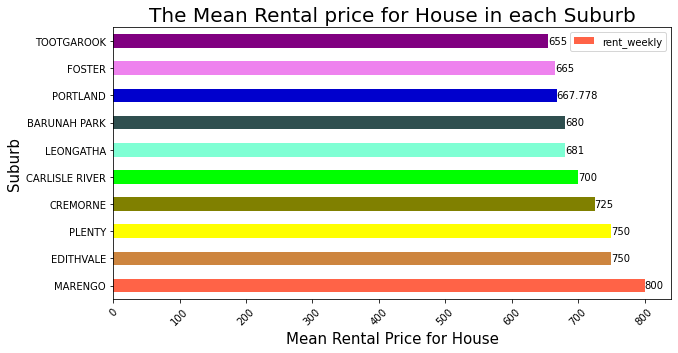

In [18]:
mean_suburb = house.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for House", fontsize=15)
plt.title("The Mean Rental price for House in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/house_suburb_mean.png')

In [ ]:
# read rental data
path = os.getcwd().replace("notebooks","") + "data/curated/"
df = pd.read_csv(path+'rental_median.csv', low_memory = True)
df = df.drop_duplicates()
df = df[['Suburb','Rental_total_Mar_2000_1b_flat', 'Rental_total_Jun_2000_1b_flat', 'Rental_total_Sep_2000_1b_flat', 'Rental_total_Dec_2000_1b_flat', 'Rental_total_Mar_2001_1b_flat', 'Rental_total_Jun_2001_1b_flat', 'Rental_total_Sep_2001_1b_flat', 'Rental_total_Dec_2001_1b_flat', 'Rental_total_Mar_2002_1b_flat', 'Rental_total_Jun_2002_1b_flat', 'Rental_total_Sep_2002_1b_flat', 'Rental_total_Dec_2002_1b_flat', 'Rental_total_Mar_2003_1b_flat', 'Rental_total_Jun_2003_1b_flat', 'Rental_total_Sep_2003_1b_flat', 'Rental_total_Dec_2003_1b_flat', 'Rental_total_Mar_2004_1b_flat', 'Rental_total_Jun_2004_1b_flat', 'Rental_total_Sep_2004_1b_flat', 'Rental_total_Dec_2004_1b_flat', 'Rental_total_Mar_2005_1b_flat', 'Rental_total_Jun_2005_1b_flat', 'Rental_total_Sep_2005_1b_flat', 'Rental_total_Dec_2005_1b_flat', 'Rental_total_Mar_2006_1b_flat', 'Rental_total_Jun_2006_1b_flat', 'Rental_total_Sep_2006_1b_flat', 'Rental_total_Dec_2006_1b_flat', 'Rental_total_Mar_2007_1b_flat', 'Rental_total_Jun_2007_1b_flat', 'Rental_total_Sep_2007_1b_flat', 'Rental_total_Dec_2007_1b_flat', 'Rental_total_Mar_2008_1b_flat', 'Rental_total_Jun_2008_1b_flat', 'Rental_total_Sep_2008_1b_flat', 'Rental_total_Dec_2008_1b_flat', 'Rental_total_Mar_2009_1b_flat', 'Rental_total_Jun_2009_1b_flat', 'Rental_total_Sep_2009_1b_flat', 'Rental_total_Dec_2009_1b_flat', 'Rental_total_Mar_2010_1b_flat', 'Rental_total_Jun_2010_1b_flat', 'Rental_total_Sep_2010_1b_flat', 'Rental_total_Dec_2010_1b_flat', 'Rental_total_Mar_2011_1b_flat', 'Rental_total_Jun_2011_1b_flat', 'Rental_total_Sep_2011_1b_flat', 'Rental_total_Dec_2011_1b_flat', 'Rental_total_Mar_2012_1b_flat', 'Rental_total_Jun_2012_1b_flat', 'Rental_total_Sep_2012_1b_flat', 'Rental_total_Dec_2012_1b_flat', 'Rental_total_Mar_2013_1b_flat', 'Rental_total_Jun_2013_1b_flat', 'Rental_total_Sep_2013_1b_flat', 'Rental_total_Dec_2013_1b_flat', 'Rental_total_Mar_2014_1b_flat', 'Rental_total_Jun_2014_1b_flat', 'Rental_total_Sep_2014_1b_flat', 'Rental_total_Dec_2014_1b_flat', 'Rental_total_Mar_2015_1b_flat', 'Rental_total_Jun_2015_1b_flat', 'Rental_total_Sep_2015_1b_flat', 'Rental_total_Dec_2015_1b_flat', 'Rental_total_Mar_2016_1b_flat', 'Rental_total_Jun_2016_1b_flat', 'Rental_total_Sep_2016_1b_flat', 'Rental_total_Dec_2016_1b_flat', 'Rental_total_Mar_2017_1b_flat', 'Rental_total_Jun_2017_1b_flat', 'Rental_total_Sep_2017_1b_flat', 'Rental_total_Dec_2017_1b_flat', 'Rental_total_Mar_2018_1b_flat', 'Rental_total_Jun_2018_1b_flat', 'Rental_total_Sep_2018_1b_flat', 'Rental_total_Dec_2018_1b_flat', 'Rental_total_Mar_2019_1b_flat', 'Rental_total_Jun_2019_1b_flat', 'Rental_total_Sep_2019_1b_flat', 'Rental_total_Dec_2019_1b_flat', 'Rental_total_Mar_2020_1b_flat', 'Rental_total_Jun_2020_1b_flat', 'Rental_total_Sep_2020_1b_flat', 'Rental_total_Dec_2020_1b_flat', 'Rental_total_Mar_2021_1b_flat', 'Rental_total_Jun_2021_1b_flat', 'Rental_total_Mar_2000_2b_flat', 'Rental_total_Jun_2000_2b_flat', 'Rental_total_Sep_2000_2b_flat', 'Rental_total_Dec_2000_2b_flat', 'Rental_total_Mar_2001_2b_flat', 'Rental_total_Jun_2001_2b_flat', 'Rental_total_Sep_2001_2b_flat', 'Rental_total_Dec_2001_2b_flat', 'Rental_total_Mar_2002_2b_flat', 'Rental_total_Jun_2002_2b_flat', 'Rental_total_Sep_2002_2b_flat', 'Rental_total_Dec_2002_2b_flat', 'Rental_total_Mar_2003_2b_flat', 'Rental_total_Jun_2003_2b_flat', 'Rental_total_Sep_2003_2b_flat', 'Rental_total_Dec_2003_2b_flat', 'Rental_total_Mar_2004_2b_flat', 'Rental_total_Jun_2004_2b_flat', 'Rental_total_Sep_2004_2b_flat', 'Rental_total_Dec_2004_2b_flat', 'Rental_total_Mar_2005_2b_flat', 'Rental_total_Jun_2005_2b_flat', 'Rental_total_Sep_2005_2b_flat', 'Rental_total_Dec_2005_2b_flat', 'Rental_total_Mar_2006_2b_flat', 'Rental_total_Jun_2006_2b_flat', 'Rental_total_Sep_2006_2b_flat', 'Rental_total_Dec_2006_2b_flat', 'Rental_total_Mar_2007_2b_flat', 'Rental_total_Jun_2007_2b_flat', 'Rental_total_Sep_2007_2b_flat', 'Rental_total_Dec_2007_2b_flat', 'Rental_total_Mar_2008_2b_flat', 'Rental_total_Jun_2008_2b_flat', 'Rental_total_Sep_2008_2b_flat', 'Rental_total_Dec_2008_2b_flat', 'Rental_total_Mar_2009_2b_flat', 'Rental_total_Jun_2009_2b_flat', 'Rental_total_Sep_2009_2b_flat', 'Rental_total_Dec_2009_2b_flat', 'Rental_total_Mar_2010_2b_flat', 'Rental_total_Jun_2010_2b_flat', 'Rental_total_Sep_2010_2b_flat', 'Rental_total_Dec_2010_2b_flat', 'Rental_total_Mar_2011_2b_flat', 'Rental_total_Jun_2011_2b_flat', 'Rental_total_Sep_2011_2b_flat', 'Rental_total_Dec_2011_2b_flat', 'Rental_total_Mar_2012_2b_flat', 'Rental_total_Jun_2012_2b_flat', 'Rental_total_Sep_2012_2b_flat', 'Rental_total_Dec_2012_2b_flat', 'Rental_total_Mar_2013_2b_flat', 'Rental_total_Jun_2013_2b_flat', 'Rental_total_Sep_2013_2b_flat', 'Rental_total_Dec_2013_2b_flat', 'Rental_total_Mar_2014_2b_flat', 'Rental_total_Jun_2014_2b_flat', 'Rental_total_Sep_2014_2b_flat', 'Rental_total_Dec_2014_2b_flat', 'Rental_total_Mar_2015_2b_flat', 'Rental_total_Jun_2015_2b_flat', 'Rental_total_Sep_2015_2b_flat', 'Rental_total_Dec_2015_2b_flat', 'Rental_total_Mar_2016_2b_flat', 'Rental_total_Jun_2016_2b_flat', 'Rental_total_Sep_2016_2b_flat', 'Rental_total_Dec_2016_2b_flat', 'Rental_total_Mar_2017_2b_flat', 'Rental_total_Jun_2017_2b_flat', 'Rental_total_Sep_2017_2b_flat', 'Rental_total_Dec_2017_2b_flat', 'Rental_total_Mar_2018_2b_flat', 'Rental_total_Jun_2018_2b_flat', 'Rental_total_Sep_2018_2b_flat', 'Rental_total_Dec_2018_2b_flat', 'Rental_total_Mar_2019_2b_flat', 'Rental_total_Jun_2019_2b_flat', 'Rental_total_Sep_2019_2b_flat', 'Rental_total_Dec_2019_2b_flat', 'Rental_total_Mar_2020_2b_flat', 'Rental_total_Jun_2020_2b_flat', 'Rental_total_Sep_2020_2b_flat', 'Rental_total_Dec_2020_2b_flat', 'Rental_total_Mar_2021_2b_flat', 'Rental_total_Jun_2021_2b_flat', 'Rental_total_Mar_2000_3b_flat', 'Rental_total_Jun_2000_3b_flat', 'Rental_total_Sep_2000_3b_flat', 'Rental_total_Dec_2000_3b_flat', 'Rental_total_Mar_2001_3b_flat', 'Rental_total_Jun_2001_3b_flat', 'Rental_total_Sep_2001_3b_flat', 'Rental_total_Dec_2001_3b_flat', 'Rental_total_Mar_2002_3b_flat', 'Rental_total_Jun_2002_3b_flat', 'Rental_total_Sep_2002_3b_flat', 'Rental_total_Dec_2002_3b_flat', 'Rental_total_Mar_2003_3b_flat', 'Rental_total_Jun_2003_3b_flat', 'Rental_total_Sep_2003_3b_flat', 'Rental_total_Dec_2003_3b_flat', 'Rental_total_Mar_2004_3b_flat', 'Rental_total_Jun_2004_3b_flat', 'Rental_total_Sep_2004_3b_flat', 'Rental_total_Dec_2004_3b_flat', 'Rental_total_Mar_2005_3b_flat', 'Rental_total_Jun_2005_3b_flat', 'Rental_total_Sep_2005_3b_flat', 'Rental_total_Dec_2005_3b_flat', 'Rental_total_Mar_2006_3b_flat', 'Rental_total_Jun_2006_3b_flat', 'Rental_total_Sep_2006_3b_flat', 'Rental_total_Dec_2006_3b_flat', 'Rental_total_Mar_2007_3b_flat', 'Rental_total_Jun_2007_3b_flat', 'Rental_total_Sep_2007_3b_flat', 'Rental_total_Dec_2007_3b_flat', 'Rental_total_Mar_2008_3b_flat', 'Rental_total_Jun_2008_3b_flat', 'Rental_total_Sep_2008_3b_flat', 'Rental_total_Dec_2008_3b_flat', 'Rental_total_Mar_2009_3b_flat', 'Rental_total_Jun_2009_3b_flat', 'Rental_total_Sep_2009_3b_flat', 'Rental_total_Dec_2009_3b_flat', 'Rental_total_Mar_2010_3b_flat', 'Rental_total_Jun_2010_3b_flat', 'Rental_total_Sep_2010_3b_flat', 'Rental_total_Dec_2010_3b_flat', 'Rental_total_Mar_2011_3b_flat', 'Rental_total_Jun_2011_3b_flat', 'Rental_total_Sep_2011_3b_flat', 'Rental_total_Dec_2011_3b_flat', 'Rental_total_Mar_2012_3b_flat', 'Rental_total_Jun_2012_3b_flat', 'Rental_total_Sep_2012_3b_flat', 'Rental_total_Dec_2012_3b_flat', 'Rental_total_Mar_2013_3b_flat', 'Rental_total_Jun_2013_3b_flat', 'Rental_total_Sep_2013_3b_flat', 'Rental_total_Dec_2013_3b_flat', 'Rental_total_Mar_2014_3b_flat', 'Rental_total_Jun_2014_3b_flat', 'Rental_total_Sep_2014_3b_flat', 'Rental_total_Dec_2014_3b_flat', 'Rental_total_Mar_2015_3b_flat', 'Rental_total_Jun_2015_3b_flat', 'Rental_total_Sep_2015_3b_flat', 'Rental_total_Dec_2015_3b_flat', 'Rental_total_Mar_2016_3b_flat', 'Rental_total_Jun_2016_3b_flat', 'Rental_total_Sep_2016_3b_flat', 'Rental_total_Dec_2016_3b_flat', 'Rental_total_Mar_2017_3b_flat', 'Rental_total_Jun_2017_3b_flat', 'Rental_total_Sep_2017_3b_flat', 'Rental_total_Dec_2017_3b_flat', 'Rental_total_Mar_2018_3b_flat', 'Rental_total_Jun_2018_3b_flat', 'Rental_total_Sep_2018_3b_flat', 'Rental_total_Dec_2018_3b_flat', 'Rental_total_Mar_2019_3b_flat', 'Rental_total_Jun_2019_3b_flat', 'Rental_total_Sep_2019_3b_flat', 'Rental_total_Dec_2019_3b_flat', 'Rental_total_Mar_2020_3b_flat', 'Rental_total_Jun_2020_3b_flat', 'Rental_total_Sep_2020_3b_flat', 'Rental_total_Dec_2020_3b_flat', 'Rental_total_Mar_2021_3b_flat', 'Rental_total_Jun_2021_3b_flat', 'Rental_total_Mar_2000_2b_house', 'Rental_total_Jun_2000_2b_house', 'Rental_total_Sep_2000_2b_house', 'Rental_total_Dec_2000_2b_house', 'Rental_total_Mar_2001_2b_house', 'Rental_total_Jun_2001_2b_house', 'Rental_total_Sep_2001_2b_house', 'Rental_total_Dec_2001_2b_house', 'Rental_total_Mar_2002_2b_house', 'Rental_total_Jun_2002_2b_house', 'Rental_total_Sep_2002_2b_house', 'Rental_total_Dec_2002_2b_house', 'Rental_total_Mar_2003_2b_house', 'Rental_total_Jun_2003_2b_house', 'Rental_total_Sep_2003_2b_house', 'Rental_total_Dec_2003_2b_house', 'Rental_total_Mar_2004_2b_house', 'Rental_total_Jun_2004_2b_house', 'Rental_total_Sep_2004_2b_house', 'Rental_total_Dec_2004_2b_house', 'Rental_total_Mar_2005_2b_house', 'Rental_total_Jun_2005_2b_house', 'Rental_total_Sep_2005_2b_house', 'Rental_total_Dec_2005_2b_house', 'Rental_total_Mar_2006_2b_house', 'Rental_total_Jun_2006_2b_house', 'Rental_total_Sep_2006_2b_house', 'Rental_total_Dec_2006_2b_house', 'Rental_total_Mar_2007_2b_house', 'Rental_total_Jun_2007_2b_house', 'Rental_total_Sep_2007_2b_house', 'Rental_total_Dec_2007_2b_house', 'Rental_total_Mar_2008_2b_house', 'Rental_total_Jun_2008_2b_house', 'Rental_total_Sep_2008_2b_house', 'Rental_total_Dec_2008_2b_house', 'Rental_total_Mar_2009_2b_house', 'Rental_total_Jun_2009_2b_house', 'Rental_total_Sep_2009_2b_house', 'Rental_total_Dec_2009_2b_house', 'Rental_total_Mar_2010_2b_house', 'Rental_total_Jun_2010_2b_house', 'Rental_total_Sep_2010_2b_house', 'Rental_total_Dec_2010_2b_house', 'Rental_total_Mar_2011_2b_house', 'Rental_total_Jun_2011_2b_house', 'Rental_total_Sep_2011_2b_house', 'Rental_total_Dec_2011_2b_house', 'Rental_total_Mar_2012_2b_house', 'Rental_total_Jun_2012_2b_house', 'Rental_total_Sep_2012_2b_house', 'Rental_total_Dec_2012_2b_house', 'Rental_total_Mar_2013_2b_house', 'Rental_total_Jun_2013_2b_house', 'Rental_total_Sep_2013_2b_house', 'Rental_total_Dec_2013_2b_house', 'Rental_total_Mar_2014_2b_house', 'Rental_total_Jun_2014_2b_house', 'Rental_total_Sep_2014_2b_house', 'Rental_total_Dec_2014_2b_house', 'Rental_total_Mar_2015_2b_house', 'Rental_total_Jun_2015_2b_house', 'Rental_total_Sep_2015_2b_house', 'Rental_total_Dec_2015_2b_house', 'Rental_total_Mar_2016_2b_house', 'Rental_total_Jun_2016_2b_house', 'Rental_total_Sep_2016_2b_house', 'Rental_total_Dec_2016_2b_house', 'Rental_total_Mar_2017_2b_house', 'Rental_total_Jun_2017_2b_house', 'Rental_total_Sep_2017_2b_house', 'Rental_total_Dec_2017_2b_house', 'Rental_total_Mar_2018_2b_house', 'Rental_total_Jun_2018_2b_house', 'Rental_total_Sep_2018_2b_house', 'Rental_total_Dec_2018_2b_house', 'Rental_total_Mar_2019_2b_house', 'Rental_total_Jun_2019_2b_house', 'Rental_total_Sep_2019_2b_house', 'Rental_total_Dec_2019_2b_house', 'Rental_total_Mar_2020_2b_house', 'Rental_total_Jun_2020_2b_house', 'Rental_total_Sep_2020_2b_house', 'Rental_total_Dec_2020_2b_house', 'Rental_total_Mar_2021_2b_house', 'Rental_total_Jun_2021_2b_house', 'Rental_total_Mar_2000_3b_house', 'Rental_total_Jun_2000_3b_house', 'Rental_total_Sep_2000_3b_house', 'Rental_total_Dec_2000_3b_house', 'Rental_total_Mar_2001_3b_house', 'Rental_total_Jun_2001_3b_house', 'Rental_total_Sep_2001_3b_house', 'Rental_total_Dec_2001_3b_house', 'Rental_total_Mar_2002_3b_house', 'Rental_total_Jun_2002_3b_house', 'Rental_total_Sep_2002_3b_house', 'Rental_total_Dec_2002_3b_house', 'Rental_total_Mar_2003_3b_house', 'Rental_total_Jun_2003_3b_house', 'Rental_total_Sep_2003_3b_house', 'Rental_total_Dec_2003_3b_house', 'Rental_total_Mar_2004_3b_house', 'Rental_total_Jun_2004_3b_house', 'Rental_total_Sep_2004_3b_house', 'Rental_total_Dec_2004_3b_house', 'Rental_total_Mar_2005_3b_house', 'Rental_total_Jun_2005_3b_house', 'Rental_total_Sep_2005_3b_house', 'Rental_total_Dec_2005_3b_house', 'Rental_total_Mar_2006_3b_house', 'Rental_total_Jun_2006_3b_house', 'Rental_total_Sep_2006_3b_house', 'Rental_total_Dec_2006_3b_house', 'Rental_total_Mar_2007_3b_house', 'Rental_total_Jun_2007_3b_house', 'Rental_total_Sep_2007_3b_house', 'Rental_total_Dec_2007_3b_house', 'Rental_total_Mar_2008_3b_house', 'Rental_total_Jun_2008_3b_house', 'Rental_total_Sep_2008_3b_house', 'Rental_total_Dec_2008_3b_house', 'Rental_total_Mar_2009_3b_house', 'Rental_total_Jun_2009_3b_house', 'Rental_total_Sep_2009_3b_house', 'Rental_total_Dec_2009_3b_house', 'Rental_total_Mar_2010_3b_house', 'Rental_total_Jun_2010_3b_house', 'Rental_total_Sep_2010_3b_house', 'Rental_total_Dec_2010_3b_house', 'Rental_total_Mar_2011_3b_house', 'Rental_total_Jun_2011_3b_house', 'Rental_total_Sep_2011_3b_house', 'Rental_total_Dec_2011_3b_house', 'Rental_total_Mar_2012_3b_house', 'Rental_total_Jun_2012_3b_house', 'Rental_total_Sep_2012_3b_house', 'Rental_total_Dec_2012_3b_house', 'Rental_total_Mar_2013_3b_house', 'Rental_total_Jun_2013_3b_house', 'Rental_total_Sep_2013_3b_house', 'Rental_total_Dec_2013_3b_house', 'Rental_total_Mar_2014_3b_house', 'Rental_total_Jun_2014_3b_house', 'Rental_total_Sep_2014_3b_house', 'Rental_total_Dec_2014_3b_house', 'Rental_total_Mar_2015_3b_house', 'Rental_total_Jun_2015_3b_house', 'Rental_total_Sep_2015_3b_house', 'Rental_total_Dec_2015_3b_house', 'Rental_total_Mar_2016_3b_house', 'Rental_total_Jun_2016_3b_house', 'Rental_total_Sep_2016_3b_house', 'Rental_total_Dec_2016_3b_house', 'Rental_total_Mar_2017_3b_house', 'Rental_total_Jun_2017_3b_house', 'Rental_total_Sep_2017_3b_house', 'Rental_total_Dec_2017_3b_house', 'Rental_total_Mar_2018_3b_house', 'Rental_total_Jun_2018_3b_house', 'Rental_total_Sep_2018_3b_house', 'Rental_total_Dec_2018_3b_house', 'Rental_total_Mar_2019_3b_house', 'Rental_total_Jun_2019_3b_house', 'Rental_total_Sep_2019_3b_house', 'Rental_total_Dec_2019_3b_house', 'Rental_total_Mar_2020_3b_house', 'Rental_total_Jun_2020_3b_house', 'Rental_total_Sep_2020_3b_house', 'Rental_total_Dec_2020_3b_house', 'Rental_total_Mar_2021_3b_house', 'Rental_total_Jun_2021_3b_house', 'Rental_total_Mar_2000_4b_house', 'Rental_total_Jun_2000_4b_house', 'Rental_total_Sep_2000_4b_house', 'Rental_total_Dec_2000_4b_house', 'Rental_total_Mar_2001_4b_house', 'Rental_total_Jun_2001_4b_house', 'Rental_total_Sep_2001_4b_house', 'Rental_total_Dec_2001_4b_house', 'Rental_total_Mar_2002_4b_house', 'Rental_total_Jun_2002_4b_house', 'Rental_total_Sep_2002_4b_house', 'Rental_total_Dec_2002_4b_house', 'Rental_total_Mar_2003_4b_house', 'Rental_total_Jun_2003_4b_house', 'Rental_total_Sep_2003_4b_house', 'Rental_total_Dec_2003_4b_house', 'Rental_total_Mar_2004_4b_house', 'Rental_total_Jun_2004_4b_house', 'Rental_total_Sep_2004_4b_house', 'Rental_total_Dec_2004_4b_house', 'Rental_total_Mar_2005_4b_house', 'Rental_total_Jun_2005_4b_house', 'Rental_total_Sep_2005_4b_house', 'Rental_total_Dec_2005_4b_house', 'Rental_total_Mar_2006_4b_house', 'Rental_total_Jun_2006_4b_house', 'Rental_total_Sep_2006_4b_house', 'Rental_total_Dec_2006_4b_house', 'Rental_total_Mar_2007_4b_house', 'Rental_total_Jun_2007_4b_house', 'Rental_total_Sep_2007_4b_house', 'Rental_total_Dec_2007_4b_house', 'Rental_total_Mar_2008_4b_house', 'Rental_total_Jun_2008_4b_house', 'Rental_total_Sep_2008_4b_house', 'Rental_total_Dec_2008_4b_house', 'Rental_total_Mar_2009_4b_house', 'Rental_total_Jun_2009_4b_house', 'Rental_total_Sep_2009_4b_house', 'Rental_total_Dec_2009_4b_house', 'Rental_total_Mar_2010_4b_house', 'Rental_total_Jun_2010_4b_house', 'Rental_total_Sep_2010_4b_house', 'Rental_total_Dec_2010_4b_house', 'Rental_total_Mar_2011_4b_house', 'Rental_total_Jun_2011_4b_house', 'Rental_total_Sep_2011_4b_house', 'Rental_total_Dec_2011_4b_house', 'Rental_total_Mar_2012_4b_house', 'Rental_total_Jun_2012_4b_house', 'Rental_total_Sep_2012_4b_house', 'Rental_total_Dec_2012_4b_house', 'Rental_total_Mar_2013_4b_house', 'Rental_total_Jun_2013_4b_house', 'Rental_total_Sep_2013_4b_house', 'Rental_total_Dec_2013_4b_house', 'Rental_total_Mar_2014_4b_house', 'Rental_total_Jun_2014_4b_house', 'Rental_total_Sep_2014_4b_house', 'Rental_total_Dec_2014_4b_house', 'Rental_total_Mar_2015_4b_house', 'Rental_total_Jun_2015_4b_house', 'Rental_total_Sep_2015_4b_house', 'Rental_total_Dec_2015_4b_house', 'Rental_total_Mar_2016_4b_house', 'Rental_total_Jun_2016_4b_house', 'Rental_total_Sep_2016_4b_house', 'Rental_total_Dec_2016_4b_house', 'Rental_total_Mar_2017_4b_house', 'Rental_total_Jun_2017_4b_house', 'Rental_total_Sep_2017_4b_house', 'Rental_total_Dec_2017_4b_house', 'Rental_total_Mar_2018_4b_house', 'Rental_total_Jun_2018_4b_house', 'Rental_total_Sep_2018_4b_house', 'Rental_total_Dec_2018_4b_house', 'Rental_total_Mar_2019_4b_house', 'Rental_total_Jun_2019_4b_house', 'Rental_total_Sep_2019_4b_house', 'Rental_total_Dec_2019_4b_house', 'Rental_total_Mar_2020_4b_house', 'Rental_total_Jun_2020_4b_house', 'Rental_total_Sep_2020_4b_house', 'Rental_total_Dec_2020_4b_house', 'Rental_total_Mar_2021_4b_house', 'Rental_total_Jun_2021_4b_house', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df = df[['Suburb', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df

In [ ]:
df=df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df["date"] = df.index
df

In [ ]:
def get_date(idx):
    return idx[-8:]
df["date"] = df["date"].apply(get_date)
df

In [ ]:
df.columns[:143]

In [ ]:
for suburb in [x for x in df.columns][:143]:
    df[suburb] = df[suburb].replace("-",np.nan)
    df[suburb] = df[suburb].astype(float)
df.dtypes
df = df.fillna(0)
df

In [ ]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (50,40))
plt.xlabel('Date', fontsize=50)
plt.xticks(rotation = 45)

for suburb in df.columns:
    ax.plot(df['date'], df[suburb], color = "black",linestyle = 'solid', marker = 'o', label = suburb)

plt.legend()
fig.figure.savefig('../plots/rental.png')

In [ ]:
print([x for x in df.columns])

In [ ]:
df["Docklands"]

In [ ]:
lis = []
for i in df.columns:
    if "flat" not in i and "house" not in i:
        lis.append(i)
print(lis)

### Rent according to suburb

suburb_rent = Other_df.groupby('suburb', as_index=False).agg({'rent_weekly':'mean'})
sorted_df = suburb_rent.sort_values(by=['rent_weekly'], ascending=False, ignore_index=True)
sorted_df

In [ ]:
plt.figure(figsize=(20, 100))
plt.barh(sorted_df['suburb'], sorted_df['rent_weekly'], align='edge')
y_num=np.arange(len(suburb_rent['suburb']))
plt.ylim(min(y_num)-1,max(y_num)+1)
plt.show()